In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyrsm as rsm
import numpy as np
import datetime
import lightgbm as lgbm
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error as mse
import gc
import os
        
RANDOM_SEED = 42

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [4]:
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [5]:
train['pickupDateTime'] = pd.to_datetime(train['pickup_datetime'])
train['dropoffDateTime'] = pd.to_datetime(train['dropoff_datetime'])
train['tripDuration'] = (train['dropoffDateTime'] - train['pickupDateTime']).dt.total_seconds()/60
train['pickupDay'] = train['pickupDateTime'].dt.day
train['pickupHour'] = train['pickupDateTime'].dt.hour
train['weekDay'] = train['pickupDateTime'].dt.weekday
train['weekDay2'] = train['pickupDateTime'].dt.strftime('%A')

train.drop(['dropoffDateTime'],axis=1,inplace=True)
train.drop(['pickupDateTime'],axis=1,inplace=True)
train.drop(['dropoff_datetime'],axis=1,inplace=True)
train.drop(['pickup_datetime'],axis=1,inplace=True)



test['pickupDateTime'] = pd.to_datetime(test['pickup_datetime'])
# test['dropoffDateTime'] = pd.to_datetime(test['dropoff_datetime'])
# test['tripDuration'] = (test['dropoffDateTime'] - test['pickupDateTime']).dt.total_seconds()/60
test['pickupDay'] = test['pickupDateTime'].dt.day
# test['pickupDate'] = test['pickupDateTime'].dt.date

test['pickupHour'] = test['pickupDateTime'].dt.hour
test['weekDay'] = test['pickupDateTime'].dt.weekday
test['weekDay2'] = test['pickupDateTime'].dt.strftime('%A')


# test.drop(['dropoffDateTime'],axis=1,inplace=True)
test.drop(['pickupDateTime'],axis=1,inplace=True)
# test.drop(['dropoff_datetime'],axis=1,inplace=True)
test.drop(['pickup_datetime'],axis=1,inplace=True)

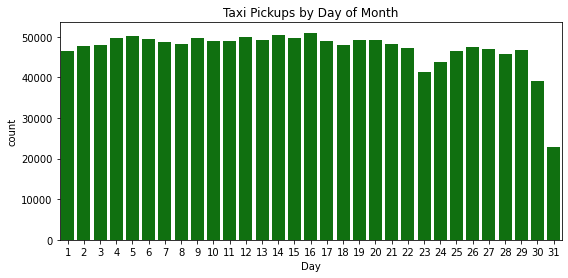

In [6]:
plt.figure(figsize=(9, 4))
pl = sns.countplot(x='pickupDay', data=train,color='green')
pl.set(title='Taxi Pickups by Day of Month', xlabel = 'Day')
plt.show()

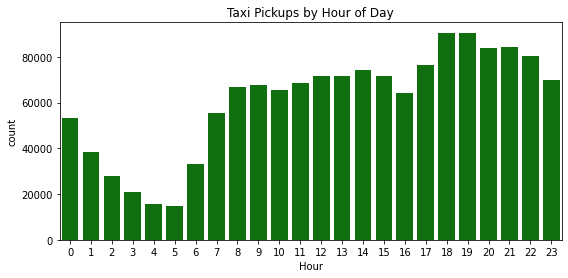

In [7]:
plt.figure(figsize=(9, 4))
pl = sns.countplot(x='pickupHour', data=train,color='green')
pl.set(title='Taxi Pickups by Hour of Day', xlabel = 'Hour')
plt.show()

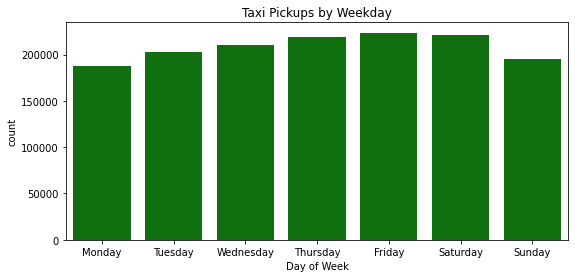

In [8]:
plt.figure(figsize=(9, 4))
weekDayOrder = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
pl = sns.countplot(x='weekDay2', data=train, order=weekDayOrder,color='green')
pl.set(title='Taxi Pickups by Weekday', xlabel = 'Day of Week')
plt.show()

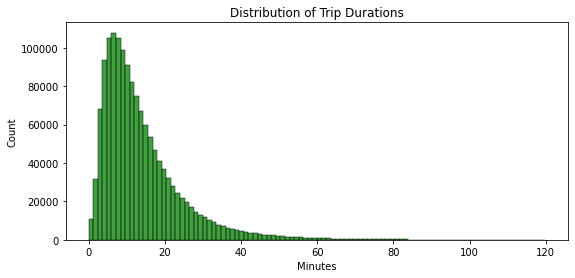

In [9]:
plt.figure(figsize=(9, 4))
maxDur = 120   
pl = sns.histplot(data=train[(train.tripDuration <= maxDur) & (train.tripDuration > 0)], x='tripDuration',color='green',bins=100)
pl.set(title='Distribution of Trip Durations', xlabel = 'Minutes')
plt.show()

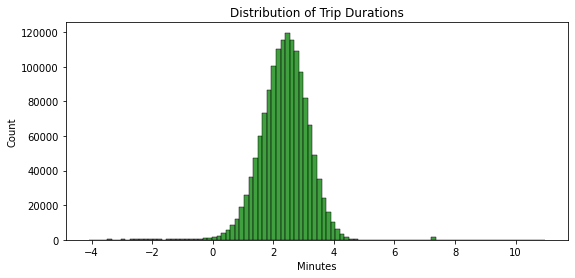

In [10]:
#Log-transformation
train['trip_duration'] = np.log(train['tripDuration'].values)
plt.figure(figsize=(9, 4))
# maxDur = 120   
pl = sns.histplot(data=train, x='trip_duration',color='green',bins=100)
pl.set(title='Distribution of Trip Durations', xlabel = 'Minutes')
plt.show()


In [11]:
#One-hot encoding binary categorical features
train = pd.concat([train, pd.get_dummies(train['store_and_fwd_flag'])], axis=1)
test = pd.concat([test, pd.get_dummies(test['store_and_fwd_flag'])], axis=1)



train = pd.concat([train, pd.get_dummies(train['vendor_id'])], axis=1)
test = pd.concat([test, pd.get_dummies(test['vendor_id'])], axis=1)

train.drop(['store_and_fwd_flag'], axis=1, inplace=True)
train.drop(['vendor_id'], axis=1, inplace=True)
test.drop(['store_and_fwd_flag'], axis=1, inplace=True)
test.drop(['vendor_id'], axis=1, inplace=True)

In [12]:
#Function aiming at calculating distances from coordinates
def ft_haversine_distance(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371 #km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

#Add distance feature
train['distance'] = ft_haversine_distance(train['pickup_latitude'].values,
                                                 train['pickup_longitude'].values, 
                                                 train['dropoff_latitude'].values,
                                                 train['dropoff_longitude'].values)
test['distance'] = ft_haversine_distance(test['pickup_latitude'].values, 
                                                test['pickup_longitude'].values, 
                                                test['dropoff_latitude'].values, 
                                                test['dropoff_longitude'].values)

In [13]:
def ft_degree(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371 #km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

#Add direction feature
train['direction'] = ft_degree(train['pickup_latitude'].values,
                                train['pickup_longitude'].values,
                                train['dropoff_latitude'].values,
                                train['dropoff_longitude'].values)
test['direction'] = ft_degree(test['pickup_latitude'].values,
                                  test['pickup_longitude'].values, 
                                  test['dropoff_latitude'].values,
                                  test['dropoff_longitude'].values)

<AxesSubplot:>

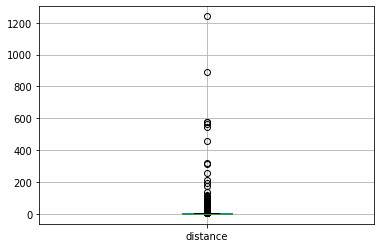

In [14]:
#Visualize distance outliers
train.boxplot(column='distance', return_type='axes')

In [15]:
train = train[(train.distance < 200)]

In [16]:
train['speed'] = train.distance / train.tripDuration

<AxesSubplot:>

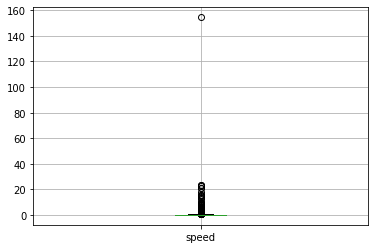

In [17]:
train.boxplot(column='speed', return_type='axes')

In [18]:
train = train[(train.speed < 30)]
train.drop(['speed'], axis=1, inplace=True)

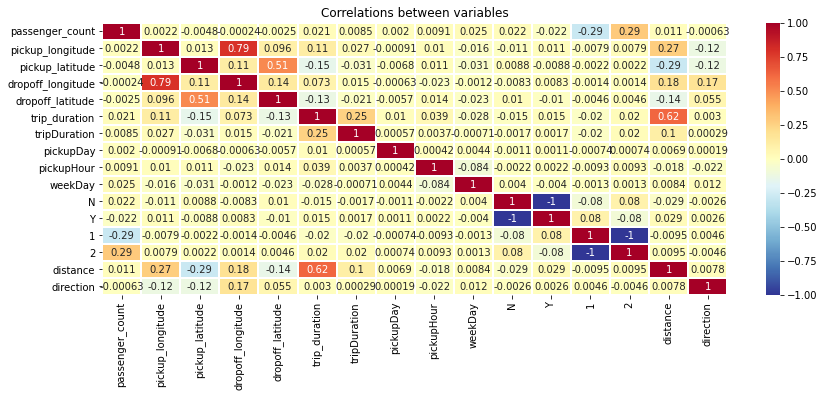

In [19]:
#Correlations between variables
fig, ax = plt.subplots(figsize=(14,5))  
sns.heatmap(data=train.corr(), annot=True, cmap = plt.cm.RdYlBu_r, linewidths=.1, ax=ax).set_title('Correlations between variables');

In [20]:
#Split the labeled data frame into two sets: features and target

y = train["trip_duration"]
train.drop(["trip_duration"], axis=1, inplace=True)
train.drop(['id'], axis=1, inplace=True)
train.drop(["weekDay2"], axis=1, inplace=True)
test.drop(["weekDay2"], axis=1, inplace=True)
train.drop(["tripDuration"], axis=1, inplace=True)
X = train

X.shape, y.shape

((1458632, 14), (1458632,))

In [21]:
#Split the labeled data frame into two sets to train then test the models
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((1166905, 14), (1166905,), (291727, 14), (291727,))

In [22]:
from sklearn.metrics import mean_squared_error as MSE

In [23]:
#XGBoost Regressor
import xgboost as xgb
from xgboost.sklearn import XGBRegressor, DMatrix

model = XGBRegressor()
model.fit(X_train, y_train)
print(model.score(X_train, y_train), model.score(X_valid, y_valid))
print(np.sqrt(MSE(y_valid, model.predict(X_valid))))

/usr/local/lib/python3.8/dist-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


0.7623557772004694 0.7496969400186079
0.3996383390081998


In [24]:
X_train.head(5)

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickupDay,pickupHour,weekDay,N,Y,1,2,distance,direction
888850,1,-73.979073,40.777458,-73.953056,40.766506,29,20,0,1,0,1,0,2.506536,119.059836
1065052,1,-73.976974,40.784931,-73.957542,40.761757,16,5,1,1,0,1,0,3.052508,147.577731
373572,2,-73.958107,40.772991,-73.957436,40.780270,31,15,1,1,0,0,1,0.811298,3.995527
1295295,6,-73.958000,40.710899,-73.961960,40.720119,29,20,0,1,0,0,1,1.078179,-18.029349
498869,1,-74.003975,40.732937,-73.982780,40.778217,8,22,4,1,0,1,0,5.342077,19.515771


<AxesSubplot:>

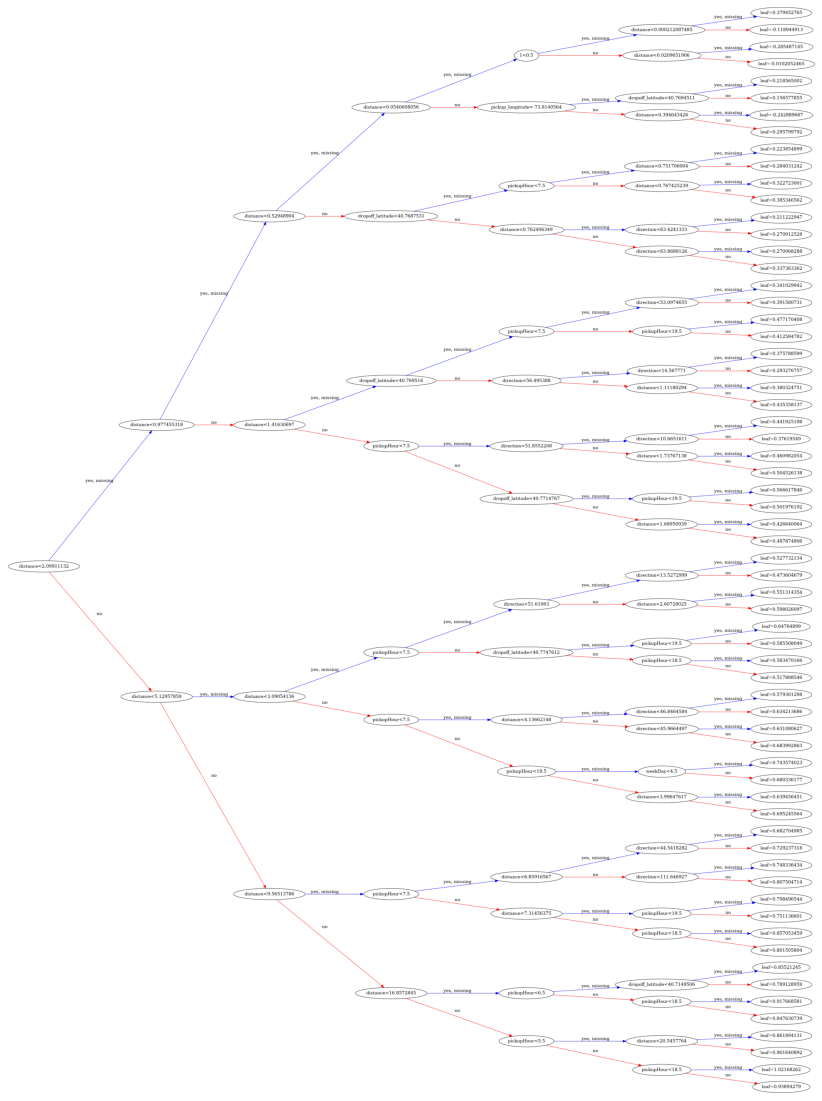

In [25]:
from xgboost import plot_tree
plt.rcParams['figure.figsize']  = 20,20
plot_tree(model,rankdir='LR')

In [26]:
# Feature Importance
importance_df = pd.DataFrame({
    'Feature' : X_train.columns,
    'Importance':model.feature_importances_
}).sort_values('Importance',ascending=False)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Feature', ylabel='Importance'>

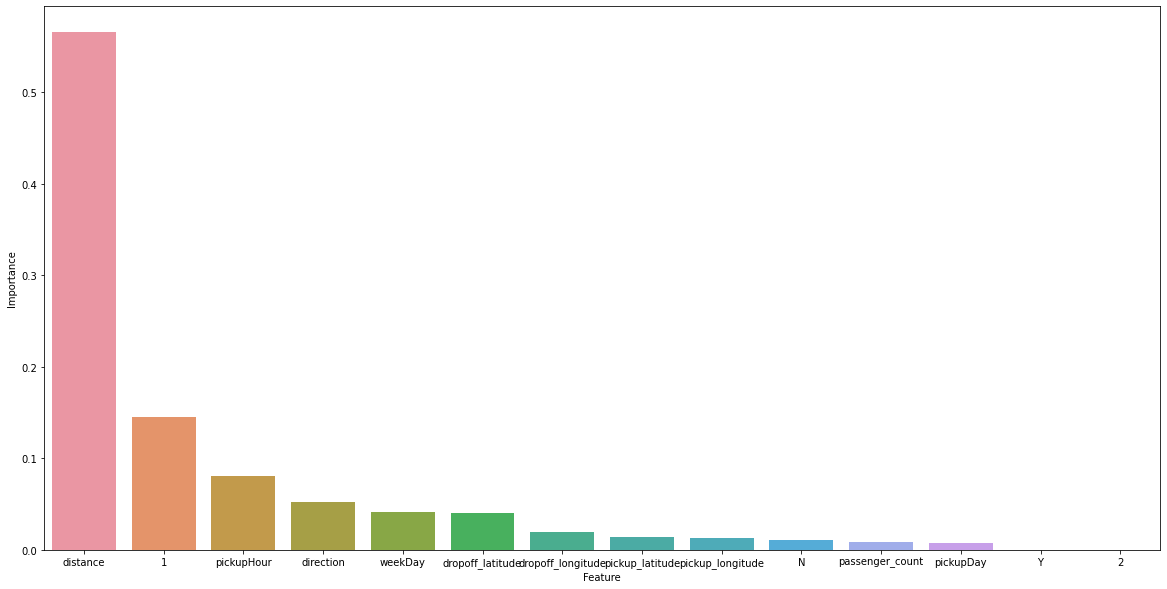

In [27]:
plt.rcParams['figure.figsize'] = 20,10
sns.barplot(importance_df['Feature'],importance_df['Importance'])

In [28]:
# Hyperparameter tuning
def test_param(**params):
    model = XGBRegressor(n_jobs=-1,random_state=42,**params)
    model.fit(X_train,y_train)
    train_mse = np.sqrt(MSE(y_train, model.predict(X_train)))
    val_mse = np.sqrt(MSE(y_valid, model.predict(X_valid)))
    print("Training MSE: %f " % train_mse)
    print("Validation MSE: %f " % val_mse)
    return train_mse,val_mse

In [29]:
def test_param_and_plot(param_name, param_values):
    train_errors, val_errors = [], [] 
    for value in param_values:
        params = {param_name: value}
        train_mse, val_mse = test_param(**params)
        train_errors.append(train_mse)
        val_errors.append(val_mse)
    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('MSE')
    plt.legend(['Training', 'Validation'])

In [37]:
test_param(max_depth=2)

/usr/local/lib/python3.8/dist-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


Training MSE: 0.431522 
Validation MSE: 0.429804 


/usr/local/lib/python3.8/dist-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.4315224416943875, 0.42980417408451166)

In [38]:
test_param(max_depth=5)

/usr/local/lib/python3.8/dist-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


Training MSE: 0.398943 
Validation MSE: 0.402542 


/usr/local/lib/python3.8/dist-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.398943211670991, 0.40254224029024044)

In [ ]:
test_param(max_depth=60)

In [ ]:
test_param_and_plot('max_depth',[x for x in range(0,110,10)])

/usr/local/lib/python3.8/dist-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


Training MSE: 0.799806 
Validation MSE: 0.798794 


/usr/local/lib/python3.8/dist-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


Training MSE: 0.326497 
Validation MSE: 0.392314 


/usr/local/lib/python3.8/dist-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


Training MSE: 0.076302 
Validation MSE: 0.408239 


In [30]:
# Cross-validation on XGBoost model --------------------------
lgb_df = lgb.Dataset(X, y)
lgb_params = {
    'metric' : 'rmse',
    'learning_rate': 0.1,
    'max_depth': 25,
    'num_leaves': 1000, 
    'objective': 'regression',
    'feature_fraction': 0.9,
    'bagging_fraction': 0.5,
    'max_bin': 1000 }

lgb.cv(lgb_params, lgb_df, stratified=False) #False is needed as it only works with classification

# Cross-validation on LightGBM model (sklearn API) ------------
from sklearn.model_selection import cross_val_score

cv_score = cross_val_score(lgbm, X, y, cv=5)
print(cv_score)
print(np.mean(cv_score))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.210881 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6078
[LightGBM] [Info] Number of data points in the train set: 1166904, number of used features: 14
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.173290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6078
[LightGBM] [Info] Number of data points in the train set: 1166904, number of used features: 14
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.225502 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6078
[LightGBM] [Info] Num

In [39]:
#Hyperparameters tuning using RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

random_grid={
'n_estimators' : [int(x) for x in np.linspace(start = 5, stop = 20, num = 16)],
'max_features' : ['auto', 'sqrt'],
'max_depth' : [int(x) for x in np.linspace(10, 110, num = 11)],
'min_samples_split' : [2, 5, 10],
'min_samples_leaf' : [1, 2, 4],
'bootstrap' : [True, False]
}
# random_grid = {'n_estimators': n_estimators, 'max_features': max_features, 'max_depth': max_depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}

random_cv = RandomizedSearchCV(estimator=lgbm, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
random_cv.fit(X_train, y_train)
best_params = random_cv.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: min_samples_leaf
[LightGBM] [Warning] Unknown parameter: bootstrap
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [40]:
best_params

{'n_estimators': 20,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 50,
 'bootstrap': False}

In [41]:
#Test the following parameters
lgb_params = {
    'metric' : 'rmse',
    'learning_rate': 0.1,
    'max_depth': 25,
    'num_leaves': 1000, 
    'objective': 'regression',
    'feature_fraction': 0.9,
    'bagging_fraction': 0.5,
    'max_bin': 1000 }

lgb_train = lgb.Dataset(X_train, y_train)
lgb_valid = lgb.Dataset(X_valid, y_valid)
lgb_model = lgb.train(lgb_params, lgb_train, num_boost_round=1500, valid_sets=[lgb_train, lgb_valid], early_stopping_rounds=5)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6079
[LightGBM] [Info] Number of data points in the train set: 1166905, number of used features: 14
[LightGBM] [Info] Start training from score 2.370413
[1]	training's rmse: 0.743851	valid_1's rmse: 0.743256
Training until validation scores don't improve for 5 rounds
[2]	training's rmse: 0.69498	valid_1's rmse: 0.694772
[3]	training's rmse: 0.652706	valid_1's rmse: 0.652995
[4]	training's rmse: 0.615598	valid_1's rmse: 0.616397
[5]	training's rmse: 0.583534	valid_1's rmse: 0.584821
[6]	training's rmse: 0.555813	valid_1's rmse: 0.557716
[7]	training's rmse: 0.532766	valid_1's rmse: 0.535278
[8]	training's rmse: 0.512073	valid_1's rmse: 0.515317
[9]	training's rmse: 0.494324	valid_1's rmse: 0.498304
[10]	training's rmse: 0.479398	vali

In [42]:
#%%time
# Training on all labeled data using the best parameters (sklearn API version)
from lightgbm import LGBMRegressor

lgbm = lgb.LGBMRegressor(n_estimators=500, num_leaves=1000, max_depth=25, objective='regression')
lgbm.fit(X, y)

LGBMRegressor(max_depth=25, n_estimators=500, num_leaves=1000,
              objective='regression')

In [43]:
#Training on all labeled data using the best parameters
lgb_df = lgb.Dataset(X, y)
lgb_model = lgb.train(lgb_params, lgb_df, num_boost_round=1500)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.163584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6078
[LightGBM] [Info] Number of data points in the train set: 1458632, number of used features: 14
[LightGBM] [Info] Start training from score 2.370177


In [44]:
#Make predictions on test data frame
test_columns = X.columns
predictions = lgb_model.predict(test[test_columns])

In [45]:
#Create a data frame designed a submission on Kaggle
submission = pd.DataFrame({'id': test.id, 'trip_duration': np.exp(predictions)})
submission.head()

,id,trip_duration
0,id3004672,11.526100
1,id3505355,9.049309
2,id1217141,6.893359
3,id2150126,15.522477
4,id1598245,6.196707
